In [1]:
# General modules
import sys
import os
import os.path
from pathlib import Path # creating directories

# math modules
import numpy as np
import tensorflow as tf # used for random seed
## math random seed module
import random as python_random

# load data
from training_modules.load_data import DATA_LOADER
# handling files
from training_modules.handling_saving_stats import get_file_path, save_history, calc_tst_acc, calc_advantage, save_file, display_results
# ## constants for DB_TYPE
from training_modules.misc import TYPE_ASCAD, TYPE_NTRU, TYPE_GAUSS, TYPE_DPA, TYPE_M4SC
# ## constants for handling file types
from training_modules.misc import MODEL_CONST, LOSS_CONST, ACC_CONST, ADV_CONST, TRN_GRPH_CONST, ADV_GRPH_CONST, TST_ACC_CONST, VAL_LOSS_CONST, VAL_ACC_CONST, VAL_ADV_CONST, TST_ADV_CONST
# ## hyper parameters
from hyper_parameters import my_seeds, tot
# training:
from training_modules.train import train_model

In [2]:
# prepare
models = dict()

# define empty history object
history = dict()

In [3]:
def read_parameters_from_file(param_filename):
    #read parameters for the train_model and load_traces functions
    #TODO: sanity checks on parameters
    param_file = open(param_filename,"r")

    #TODO: replace eval() by ast.linear_eval()
    my_parameters= eval(param_file.read())

    my_database = my_parameters["database"]
    my_database_title = my_parameters["database_title"]
    return my_database_title, my_database


+ Commense training (takes about 20 seconds per epoch)
+ Commense loading data
++ Loading schoolbook on m4sc data
++ Parse m4sc data
++ Finished parsing m4sc data
++ Normalizing traces of m4sc
++ Organizing traces
Traces shape: (20000, 18000)
++ Data dimestions are:  (20000, 18000)
+ sample 0 traces
key_idx=0...
++ calculating accuracy for seed 57935 and key 0
key_idx=1...
++ calculating accuracy for seed 57935 and key 1
key_idx=2...
++ calculating accuracy for seed 57935 and key 2
key_idx=3...
++ calculating accuracy for seed 57935 and key 3
key_idx=4...
++ calculating accuracy for seed 57935 and key 4
key_idx=5...
++ calculating accuracy for seed 57935 and key 5
key_idx=6...
++ calculating accuracy for seed 57935 and key 6
key_idx=7...
++ calculating accuracy for seed 57935 and key 7
key_idx=8...
++ calculating accuracy for seed 57935 and key 8
key_idx=9...
++ calculating accuracy for seed 57935 and key 9
key_idx=10...
++ calculating accuracy for seed 57935 and key 10
key_idx=11...
+

162/162 [==============================] - 9s 55ms/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.0181 - val_accuracy: 0.9956
Epoch 14/25
162/162 [==============================] - 9s 55ms/step - loss: 0.0021 - accuracy: 0.9997 - val_loss: 0.0113 - val_accuracy: 0.9933
Epoch 15/25
162/162 [==============================] - 9s 55ms/step - loss: 0.0016 - accuracy: 0.9996 - val_loss: 0.0111 - val_accuracy: 0.9956
Epoch 16/25
162/162 [==============================] - 9s 55ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.0104 - val_accuracy: 0.9956
Epoch 17/25
162/162 [==============================] - 9s 55ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0141 - val_accuracy: 0.9950
Epoch 18/25
162/162 [==============================] - 9s 55ms/step - loss: 0.0012 - accuracy: 0.9998 - val_loss: 0.0190 - val_accuracy: 0.9950
Epoch 19/25
162/162 [==============================] - 9s 55ms/step - loss: 8.0363e-04 - accuracy: 1.0000 - val_loss: 0.0136 - val_accuracy: 0.9950


162/162 [==============================] - 9s 55ms/step - loss: 0.0173 - accuracy: 0.9948 - val_loss: 0.0329 - val_accuracy: 0.9889
Epoch 8/25
162/162 [==============================] - 9s 55ms/step - loss: 0.0154 - accuracy: 0.9948 - val_loss: 0.0407 - val_accuracy: 0.9861
Epoch 9/25
162/162 [==============================] - 9s 55ms/step - loss: 0.0077 - accuracy: 0.9978 - val_loss: 0.0360 - val_accuracy: 0.9894
Epoch 10/25
162/162 [==============================] - 9s 55ms/step - loss: 0.0055 - accuracy: 0.9985 - val_loss: 0.0281 - val_accuracy: 0.9900
Epoch 11/25
162/162 [==============================] - 9s 55ms/step - loss: 0.0045 - accuracy: 0.9988 - val_loss: 0.0296 - val_accuracy: 0.9894
Epoch 12/25
162/162 [==============================] - 9s 55ms/step - loss: 0.0028 - accuracy: 0.9997 - val_loss: 0.0282 - val_accuracy: 0.9900
Epoch 13/25
162/162 [==============================] - 9s 55ms/step - loss: 0.0023 - accuracy: 0.9998 - val_loss: 0.0260 - val_accuracy: 0.9911
Epoch 

Epoch 2/25
162/162 [==============================] - 9s 55ms/step - loss: 0.2469 - accuracy: 0.8759 - val_loss: 4.3089 - val_accuracy: 0.6683
Epoch 3/25
162/162 [==============================] - 9s 55ms/step - loss: 0.1617 - accuracy: 0.9298 - val_loss: 0.7386 - val_accuracy: 0.7089
Epoch 4/25
162/162 [==============================] - 9s 55ms/step - loss: 0.0648 - accuracy: 0.9794 - val_loss: 0.0615 - val_accuracy: 0.9750
Epoch 5/25
162/162 [==============================] - 9s 55ms/step - loss: 0.0342 - accuracy: 0.9891 - val_loss: 0.0343 - val_accuracy: 0.9906
Epoch 6/25
162/162 [==============================] - 9s 55ms/step - loss: 0.0195 - accuracy: 0.9947 - val_loss: 0.0854 - val_accuracy: 0.9733
Epoch 7/25
162/162 [==============================] - 9s 55ms/step - loss: 0.0142 - accuracy: 0.9962 - val_loss: 0.0229 - val_accuracy: 0.9933
Epoch 8/25
162/162 [==============================] - 9s 55ms/step - loss: 0.0104 - accuracy: 0.9972 - val_loss: 0.0205 - val_accuracy: 0.9944


+ Training complete
+ Saving dictionary with all test accuracies and test advantages of all seeds (and keys if those exist)
++ Saving:  ../sca_m4sc_new_disrib_cnn3_lr1e-4_ep25_TstLen2000/tst_acc.npy
++ Saving:  ../sca_m4sc_new_disrib_cnn3_lr1e-4_ep25_TstLen2000/tst_adv.npy
adv:  {0: ((57935, 0), -1.631578947368421), 1: ((57935, 1), -1.2328947368421053), 2: ((57935, 2), -0.2881578947368422), 3: ((57935, 3), -1.0894736842105264), 4: ((57935, 4), -0.29736842105263156), 5: ((57935, 5), -1.631578947368421), 6: ((57935, 6), -0.506578947368421), 7: ((57935, 7), -1.1171052631578946), 8: ((57935, 8), 0.10000000000000009), 9: ((57935, 9), -1.6092105263157896), 10: ((57935, 10), -1.6302631578947369), 11: ((57935, 11), -1.631578947368421), 12: ((57935, 12), -0.5407894736842106), 13: ((57935, 13), -1.5868421052631578), 14: ((57935, 14), -1.180263157894737), 15: ((57935, 15), -1.631578947368421), 16: ((57935, 16), -1.2144736842105264), 17: ((57935, 17), 0.5723684210526316), 18: ((57935, 18), 0.9776

<Figure size 432x288 with 0 Axes>

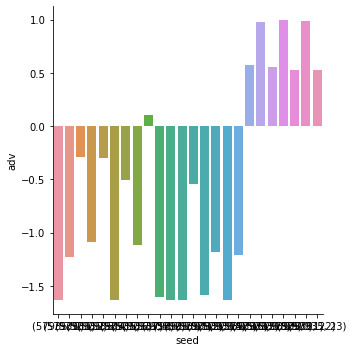

In [4]:
## ASCAD: Adapted heavily by Mahmoud Gharra

# NOTE: code could take another database if it has  supported format as the one provided.


# if __name__ == "__main__":

# default parameters values
# # my_database = "../2020_APR_23/polymul32/projects/operand_scanning_32" # Loc on my personal pc
# my_database = "../chipWhisp01/projects/operand_scanning_32" # Loc on Einstein
# DB_title = "operand_scanning_32" # arbitrary name
# DB_TYPE = TYPE_NTRU


# DB_title = my_database = "../schoolbook32/schoolbook32" # loc on Einstein
# # DB_title = "schoolbook32" ## Optional... It's for the graph
# DB_TYPE = TYPE_NTRU


# # my_database = "../2020_MAR_31/ASCAD_data/ASCAD_databases/ASCAD.h5" # Loc on my personal pc
# my_database = "../PRE_MAY_06/ASCAD/ATMEGA_AES_v1/ATM_AES_v1_fixed_key/ASCAD_data/ASCAD_databases/ASCAD.h5" # Loc on Einstein
# DB_title = "ASCAD"
# DB_TYPE = TYPE_ASCAD



# my_database = "../dpa_data"
# DB_title = "DPA contest"
# DB_TYPE = TYPE_DPA


## This is an implementation of schoolbook 32 where the result is aggregated slowly key-wise (for each coeeficient in the key)

my_database = "../../2020-07-30-115642-118eafdd-ntruprime.pickle"
DB_title = "M4SC"
DB_TYPE = TYPE_M4SC


# my_database = "../GSprojectNils/projects/GStraces"
# DB_title = "Gaussian Sampler"
# DB_TYPE = TYPE_GAUSS



# TRAINING MODEL IS THE FILE, IN WHICH THE DATA SHOULD BE SAVED
# Network type simply chooses the architecture according to which the data is trained

# 'cnn' works well for operand_scanning_32 with 20 epochs batch 100 and 2 attempts

# CNN training
network_type = "cnn3" ## ATM: you can choose between 'mlp', 'cnn', 'cnn2', and 'cnn3'
# save folder
# training_model = "../debugging_file_cnn2_binary_relu_ep200_coeff_lr1e-5"
training_model = "../sca_m4sc_new_disrib_cnn3_lr1e-4_ep25_TstLen2000"
#     training_model = "training_m4sc_lastByte_pol1_mlp_batch100_epochs50_MAXATT1_lr1e-2_valid1e-1"



# create save directory, if it doesn't exist
Path(training_model).mkdir(parents=True, exist_ok=True)
    

accuracies = {}
advantages = {}
### training
print("+ Commense training (takes about 20 seconds per epoch)")
for seed in my_seeds:
    # increasing reproducability of results according to https://keras.io/getting_started/faq/
    # set PYTHONHASHSEED before running program to increase reproducability
    # You can also consider using the CPU, as GPUs are less deterministic. (CUDA="")
    np.random.seed(seed)
    python_random.seed(seed)
#     tf.random.set_random_seed(seed) # older tf versions use this
    tf.random.set_seed(seed)

    data_loader = DATA_LOADER(DB_TYPE, my_database)

    print("++ Data dimestions are: ", np.array(data_loader.X).shape)

    # sample some traces
    # Sampling traces intereferes with the resulting graph. This must mean that I'm doing that suboptimally
    # TODO: fix it, so that saved graph is correct
    print("+ sample {0} traces".format(tot))
    if tot != 0:
        sample_traces(X)
        print("+ print out list of categories:\n {}".format(np.unique(y)))
        print("+ print out shape of labels:\n {}".format(y.shape))

        
    for key_idx in range(data_loader.KEY_LENGTH):
        print('key_idx={}...'.format(key_idx))

        # If it hasn't been trained. Load a model, extract the profiling and attack traces and labels and commense the training
        ## extract profiling and testing data
        data_loader.extract_data(network_type, key_idx=key_idx)
        
        # Check if this seed key combination had been trained in the past
        ## we run individual training for each key integer
        if models.get((seed, key_idx)) is not None:
            ## calculate ACCURACY
            accuracies[(seed, key_idx)] = calc_tst_acc(data_loader, seed=seed, key_idx=key_idx)
            ## calculate ADVANTAGE
            advantages[(seed, key_idx)] = calc_advantage(accuracies.get((seed, key_idx)))
            continue

        _file_path = os.path.normpath(get_file_path(training_model, MODEL_CONST, seed, key_idx))
        if os.path.exists(_file_path) == True:
            models[(seed, key_idx)] = get_file_path(training_model, MODEL_CONST, seed, key_idx)
            ## calculate ACCURACY
            accuracies[(seed, key_idx)] = calc_tst_acc(data_loader, seed=seed, key_idx=key_idx)
            ## calculate ADVANTAGE
            advantages[(seed, key_idx)] = calc_advantage(accuracies.get((seed, key_idx)))
            continue                

        
        ## train model, get number of attempts needed and history struct
        history, att = train_model(data_loader, training_model, seed=seed, key_idx=key_idx)

        ## TODO: save hist
        print("+ save history")
        # SAVE HISTORY
        save_history(training_model, history, seed, key_idx, att)

        # add file path to list of trained models
        models[(seed, key_idx)] = get_file_path(training_model, MODEL_CONST, seed, key_idx) # TODO: models can be removed, get_file_path() is better at getting model instance
        # TODO: THE FOLLOWING 4 LINES WERE REPEATED 4 TIMES
        ## calculate test accuracy, you'll be saving them all at the end
        accuracies[(seed, key_idx)] = calc_tst_acc(data_loader, seed=seed, key_idx=key_idx)

        ## calculate ADVANTAGE
        advantages[(seed, key_idx)] = calc_advantage(accuracies.get((seed, key_idx)))


print()
print("+ Training complete")

# Save all test accuracies and advantages
print("+ Saving dictionary with all test accuracies and test advantages of all seeds (and keys if those exist)")
save_file(training_model, accuracies, case=TST_ACC_CONST)
save_file(training_model, advantages, case=TST_ADV_CONST)



# TODO: replace calculation of advantage with loading of it
display_results(models, accuracies, advantages, training_model, DB_TYPE = TYPE_ASCAD)






In [5]:
# from tensorflow.python.client import device_lib
# print(device_lib.list_local_devices())